<div style="color:#800080; font-size:28px; font-weight:bold;">
    1. Título y datos del alumno    
</div>

**Título: Predecir la aparición de diabetes basándose en medidas de diagnóstico**
  
**Autores:**  
- Cisneros Lovaton, Sarai
- Urbina Castro, George

<div style="color:#800080; font-size:28px; font-weight:bold;">
    2. Introducción y Contexto del Negocio  
</div>

**Contexto**  
El Instituto Nacional de Diabetes y Enfermedades Digestivas y Renales quiere predecir diagnósticamente si un paciente padece diabetes, basándose en ciertas mediciones diagnósticas. En particular, todos los pacientes aquí presentes son mujeres de al menos 21 años de ascendencia indígena pima.

**Definición de variables:**

Variables Predictoras:
- Pregnancies: Número de veces que quedó embarazada
- Glucose: Concentración de glucosa plasmática a las 2 horas en una prueba de tolerancia a la glucosa oral
- BloodPressure: Presión arterial diastólica (mm Hg)
- SkinThickness: Espesor del pliegue cutáneo del tríceps (mm)
- Insulin: Insulina sérica de 2 horas (mu U/ml)
- BMI: Índice de masa corporal (peso en kg/(altura en m)^2)
- DiabetesPedigreeFunction: Función del pedigrí de la diabetes
- Age: Edad (años) 

Variable Objetivo (Target):
- Outcome (0: No tiene diabetes / 1: Tiene diabetes)


**Pregunta de negocio que intentas responder:**  
¿Puede construir un modelo de aprendizaje automático para predecir con precisión si los pacientes en el conjunto de datos tienen diabetes o no?

<div style="color:#800080; font-size:28px; font-weight:bold;">
    3. Carga de datos
</div>

In [67]:
# 1. Configuración Inicial
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt  # Agregado para visualizaciones
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.linear_model import LogisticRegression
# Agregado ConfusionMatrixDisplay
from sklearn.metrics import classification_report, roc_auc_score, ConfusionMatrixDisplay, accuracy_score
from category_encoders import TargetEncoder
import joblib

from sklearn.dummy import DummyClassifier
#from sklearn.metrics import (accuracy_score, precision_score, recall_score, f1_score,roc_auc_score, confusion_matrix, classification_report)

import seaborn as sns
#from sklearn import set_config

# Semilla aleatoria
RANDOM_STATE = 42

In [68]:
!pip install kagglehub

In [69]:
import os
import kagglehub

# Cambiar ruta de almacenamiento
os.environ["KAGGLEHUB_CACHE"] = "../data/"
path = kagglehub.dataset_download("uciml/pima-indians-diabetes-database")

print("Descargado en:", path)

Descargado en: ../data/datasets\uciml\pima-indians-diabetes-database\versions\1


In [70]:
df = pd.read_csv("../data/datasets/uciml/pima-indians-diabetes-database/versions/1/diabetes.csv")
df.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1


In [71]:
# Ver columnas disponibles
print("Columnas:", df.columns.tolist()[:10], "...")
print(f"Dimensiones: {df.shape}")

# Separar Features y Target(Outcome)
TARGET_COL = 'Outcome'
COLS_TO_DROP = [TARGET_COL]

# Eliminamos explícitamente columnas que no aportan valor predictivo o son identificadores.
X = df.drop([col for col in COLS_TO_DROP if col in df.columns], axis=1)
y = df[TARGET_COL]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=RANDOM_STATE)

print(f"\nTrain shape: {X_train.shape}")
print(f"Test shape: {X_test.shape}")
print(f"Distribución target (Train): {y_train.value_counts(normalize=True).to_dict()}")
print("")

X_train.info()


Columnas: ['Pregnancies', 'Glucose', 'BloodPressure', 'SkinThickness', 'Insulin', 'BMI', 'DiabetesPedigreeFunction', 'Age', 'Outcome'] ...
Dimensiones: (768, 9)

Train shape: (614, 8)
Test shape: (154, 8)
Distribución target (Train): {0: 0.6514657980456026, 1: 0.3485342019543974}

<class 'pandas.core.frame.DataFrame'>
Index: 614 entries, 353 to 107
Data columns (total 8 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Pregnancies               614 non-null    int64  
 1   Glucose                   614 non-null    int64  
 2   BloodPressure             614 non-null    int64  
 3   SkinThickness             614 non-null    int64  
 4   Insulin                   614 non-null    int64  
 5   BMI                       614 non-null    float64
 6   DiabetesPedigreeFunction  614 non-null    float64
 7   Age                       614 non-null    int64  
dtypes: float64(2), int64(6)
memory usage: 43.2 KB


<div style="color:#800080; font-size:28px; font-weight:bold;">
    4. Explotación de Datos (EDA)
</div>

In [72]:
num_cols = X_train.select_dtypes(include=[np.number]).columns.tolist()
print("Columnas Numéricas detectadas:", num_cols)

# columnas que en Pima usan 0 como indicador implícito de NA
suspect_zero_cols = [c for c in ['Glucose','BloodPressure','SkinThickness','Insulin','BMI'] if c in num_cols]
print("")
print("Columnas donde 0 puede significar missing:", suspect_zero_cols)
print("")
for c in suspect_zero_cols:
    zeros = (X_train[c] == 0).sum()
    print(f"  {c}: zeros = {zeros} ({zeros/len(X_train)*100:.2f}%)")

Columnas Numéricas detectadas: ['Pregnancies', 'Glucose', 'BloodPressure', 'SkinThickness', 'Insulin', 'BMI', 'DiabetesPedigreeFunction', 'Age']

Columnas donde 0 puede significar missing: ['Glucose', 'BloodPressure', 'SkinThickness', 'Insulin', 'BMI']

  Glucose: zeros = 4 (0.65%)
  BloodPressure: zeros = 23 (3.75%)
  SkinThickness: zeros = 175 (28.50%)
  Insulin: zeros = 290 (47.23%)
  BMI: zeros = 9 (1.47%)


In [73]:
X_train.describe().T


,count,mean,std,min,25%,50%,75%,max
Pregnancies,614.0,3.819218,3.314148,0.000,1.000,3.0000,6.00000,17.000
Glucose,614.0,120.908795,31.561093,0.000,99.000,117.0000,140.00000,199.000
BloodPressure,614.0,69.442997,18.402581,0.000,62.500,72.0000,80.00000,122.000
SkinThickness,614.0,20.776873,15.856433,0.000,0.000,23.0000,32.00000,99.000
Insulin,614.0,78.666124,107.736572,0.000,0.000,40.5000,130.00000,744.000
BMI,614.0,31.973290,7.861364,0.000,27.500,32.3000,36.50000,67.100
DiabetesPedigreeFunction,614.0,0.477428,0.330300,0.084,0.245,0.3825,0.63925,2.329
Age,614.0,33.366450,11.833438,21.000,24.000,29.0000,41.00000,81.000


In [74]:
# Identificar tipos de columnas automáticamente
num_features = X_train.select_dtypes(include=['int64', 'float64']).columns.tolist()
cat_features = X_train.select_dtypes(include=['object', 'category']).columns.tolist()

print(f"Features numéricas ({len(num_features)}): {num_features[:10]}...")
print(f"Features categóricas ({len(cat_features)}): {cat_features[:10] if cat_features else 'Ninguna'}")

# Verificar valores nulos
null_pct = (X_train.isnull().sum() / len(X_train)
            * 100).sort_values(ascending=False)
print(f"\nColumnas con más nulos:\n{null_pct.head()}")



Features numéricas (8): ['Pregnancies', 'Glucose', 'BloodPressure', 'SkinThickness', 'Insulin', 'BMI', 'DiabetesPedigreeFunction', 'Age']...
Features categóricas (0): Ninguna

Columnas con más nulos:
Pregnancies      0.0
Glucose          0.0
BloodPressure    0.0
SkinThickness    0.0
Insulin          0.0
dtype: float64


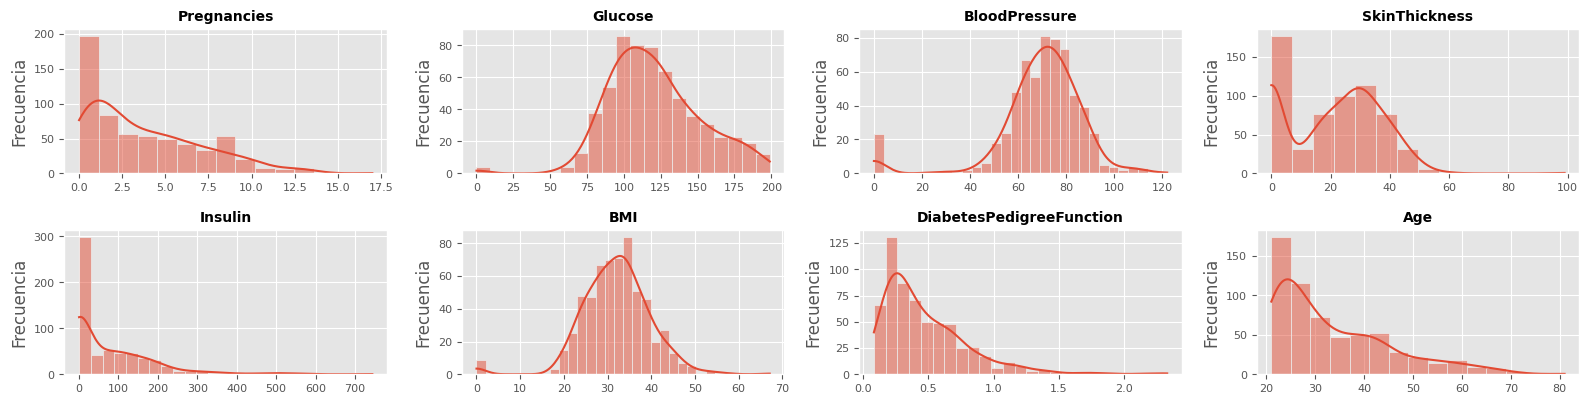

In [75]:
def plot_numeric_distributions(x):
    # Seleccionar columnas numéricas
    columnas_numeric = num_features #x.select_dtypes(include=['float64', 'int64']).columns

    # Número de variables numéricas
    num_vars = len(columnas_numeric)

    # Calcular el número de filas y columnas
    ncols = 4
    nrows = int(np.ceil(num_vars / ncols))

    # Crear subgráficos
    fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(ncols * 4, nrows * 2))
    axes = axes.flatten()  # Aplanar la matriz de ejes para fácil indexación

    # Graficar histogramas
    for i, colum in enumerate(columnas_numeric):
        sns.histplot(data=x, x=colum, kde=True, ax=axes[i])
        axes[i].set_title(colum, fontsize=10, fontweight="bold")
        axes[i].tick_params(labelsize=8)
        axes[i].set_xlabel("")
        axes[i].set_ylabel("Frecuencia")

    # Ocultar ejes extra
    for ax in axes[num_vars:]:
        ax.axis('off')

    fig.tight_layout()
    plt.subplots_adjust(top=0.95)
    #fig.suptitle('Distribución de variables numéricas', fontsize=12, fontweight="bold")
    plt.show()

plot_numeric_distributions(X_train)

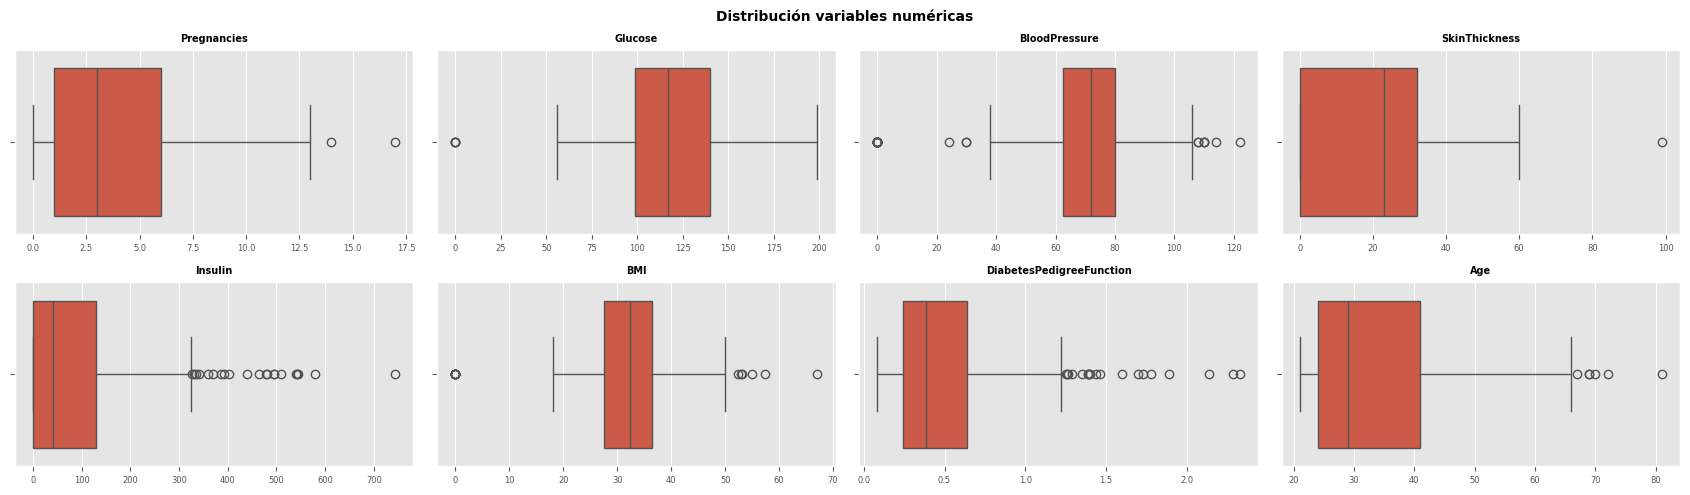

In [76]:
# Ajustar el número de subplots en función del número de columnas numéricas
fig, axes = plt.subplots(nrows=2, ncols=4, figsize=(17, 5))
axes = axes.flat
columnas_numeric = num_features #df.select_dtypes(include=['float64', 'int64']).drop(columns=['Outcome']).columns

for i, colum in enumerate(columnas_numeric):
    sns.boxplot(data=X_train, x=colum, ax=axes[i])
    axes[i].set_title(colum, fontsize=7, fontweight="bold")
    axes[i].tick_params(labelsize=6)
    axes[i].set_xlabel("")

fig.tight_layout()
plt.subplots_adjust(top=0.9)
fig.suptitle('Distribución variables numéricas', fontsize=10, fontweight="bold")
plt.show()


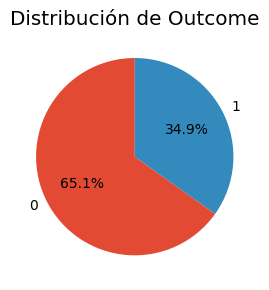

In [77]:
conteo = y_train.value_counts()

plt.figure(figsize=(3,3))
plt.pie(
    conteo.values,
    labels=conteo.index,
    autopct='%1.1f%%',
    startangle=90
)

plt.title("Distribución de Outcome")
plt.tight_layout()
plt.show()

<div style="color:#800080; font-size:28px; font-weight:bold;">
    5. Preprocesamiento (Pipeline)
</div>

In [78]:
cols_validar_ceros = ['Glucose','BloodPressure','SkinThickness','Insulin','BMI']
cols_no_validar_ceros = ['Pregnancies','DiabetesPedigreeFunction','Age']

# Pipeline para columnas con ceros sospechosos
pipeline_ceros = Pipeline([
    ('imputer', SimpleImputer(missing_values=0, strategy='median')),
    ('scaler', StandardScaler())
])

# Pipeline para columnas sin ceros sospechosos
pipeline_normales = Pipeline([
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

In [79]:
preprocessor = ColumnTransformer(
    transformers=[
        ('pipeline_ceros', pipeline_ceros, cols_validar_ceros),
        ('pipeline_normales', pipeline_normales, cols_no_validar_ceros)
    ],
    verbose_feature_names_out=False,
    remainder='drop'  # Lo que no listamos, se borra
)

# Visualizar el preprocesador (sin ajustar aún)
preprocessor

,transformers,"[('pipeline_ceros', ...), ('pipeline_normales', ...)]"
,remainder,'drop'
,sparse_threshold,0.3
,n_jobs,None
,transformer_weights,None
,verbose,False
,verbose_feature_names_out,False
,force_int_remainder_cols,'deprecated'
,missing_values,0
,strategy,'median'
,fill_value,None


<div style="color:#800080; font-size:28px; font-weight:bold;">
    6. Modelado y Baseline
</div>

In [80]:
model_dummy_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('dummy', DummyClassifier(strategy='most_frequent'))
])

model_Logistic_pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('classifier', LogisticRegression(
        class_weight='balanced', solver='liblinear', random_state=42))
])

# model_dummy_pipeline
# model_Logistic_pipeline


<div style="color:#800080; font-size:28px; font-weight:bold;">
    7. Evaluación y métricas
</div>

In [81]:
# =============================================
# 🎯 EJEMPLO 3: Dummy vs Modelo Real
# =============================================

# Modelos a comparar
modelos = {
    'Dummy (most_frequent)': model_dummy_pipeline.fit(X_train, y_train),
    'Logistic Regression': model_Logistic_pipeline.fit(X_train, y_train)
}

resultados_comparacion = []

for nombre, modelo in modelos.items():
    modelo.fit(X_train, y_train)
    y_pred = modelo.predict(X_test)    

    resultados_comparacion.append({
        'Modelo': nombre,
        'Accuracy': accuracy_score(y_test, y_pred),
        'Es Baseline': 'Dummy' in nombre
    })    

df_comp = pd.DataFrame(resultados_comparacion)
print('###' * 30)
print("📊 COMPARACIÓN: \n")
print(df_comp.to_string(index=False))
print('###' * 30)
# print("\n💡 Si tu modelo no supera al Dummy, ¡no está aprendiendo!")

print('')

##########################################################################################
📊 COMPARACIÓN: 

               Modelo  Accuracy  Es Baseline
Dummy (most_frequent)  0.649351         True
  Logistic Regression  0.733766        False
##########################################################################################



In [82]:
# =============================================
# 🎯 EJEMPLO 3: Dummy vs Modelo Real
# =============================================

for nombre, modelo in modelos.items():
    modelo.fit(X_train, y_train)
    y_pred = modelo.predict(X_test)
    y_proba = modelo.predict_proba(X_test)[:, 1]
    
    print('---' * 30)
    print(nombre)
    print('---' * 30)
    print(classification_report(y_test, y_pred))
    print(f"ROC-AUC Score: {roc_auc_score(y_test, y_proba):.4f}")
    print('')


------------------------------------------------------------------------------------------
Dummy (most_frequent)
------------------------------------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.65      1.00      0.79       100
           1       0.00      0.00      0.00        54

    accuracy                           0.65       154
   macro avg       0.32      0.50      0.39       154
weighted avg       0.42      0.65      0.51       154

ROC-AUC Score: 0.5000

------------------------------------------------------------------------------------------
Logistic Regression
------------------------------------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.82      0.75      0.79       100
           1       0.60      0.70      0.65        54

    accuracy                           0.73       154
   macro avg       0.71   

c:\Users\Usuario\miniconda3\envs\ml_pro\lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
c:\Users\Usuario\miniconda3\envs\ml_pro\lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
c:\Users\Usuario\miniconda3\envs\ml_pro\lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", 

In [83]:
from sklearn.model_selection import train_test_split, cross_val_score

# Pipeline completo con Cross-Validation
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

# Cross-Validation
print("📊 EVALUACIÓN CON CROSS-VALIDATION (5-Fold)\n")
print(f"{'Modelo':<30} {'Mean CV Score':>15} {'Std':>10}")
print("="*55)

for nombre, pipe in modelos.items():
    scores = cross_val_score(pipe, X_train, y_train, cv=5, scoring='accuracy')
    print(f"{nombre:<30} {scores.mean():>15.2%} {scores.std():>10.2%}")

print("\n✅ Los modelos reales superan claramente al Dummy")

📊 EVALUACIÓN CON CROSS-VALIDATION (5-Fold)

Modelo                           Mean CV Score        Std
Dummy (most_frequent)                   65.15%      0.21%
Logistic Regression                     75.09%      3.70%

✅ Los modelos reales superan claramente al Dummy


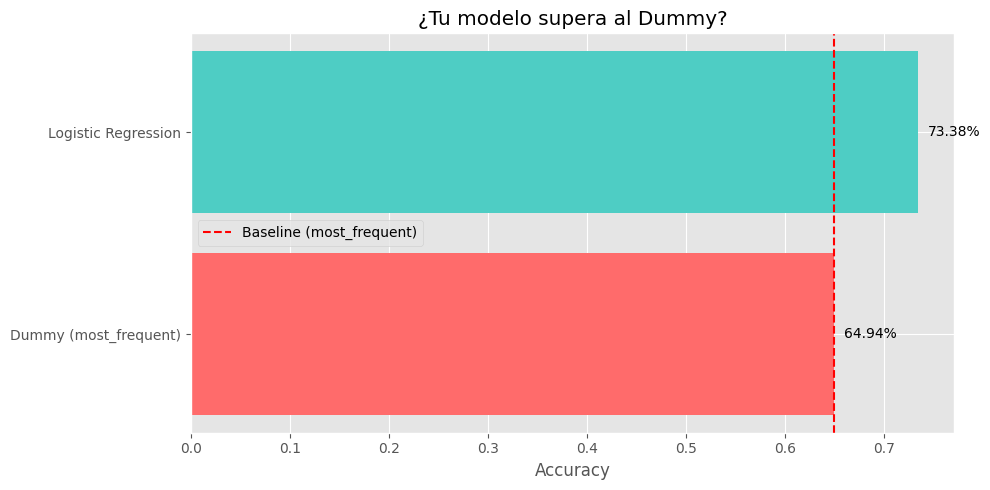

In [84]:
# Visualización de la comparación
fig, ax = plt.subplots(figsize=(10, 5))

colores = ['#ff6b6b' if es_baseline else '#4ecdc4' 
           for es_baseline in df_comp['Es Baseline']]

bars = ax.barh(df_comp['Modelo'], df_comp['Accuracy'], color=colores)
ax.axvline(x=df_comp[df_comp['Modelo']=='Dummy (most_frequent)']['Accuracy'].values[0], 
           color='red', linestyle='--', label='Baseline (most_frequent)')

ax.set_xlabel('Accuracy')
ax.set_title('¿Tu modelo supera al Dummy?')
ax.legend()

# Añadir valores en las barras
for bar, acc in zip(bars, df_comp['Accuracy']):
    ax.text(acc + 0.01, bar.get_y() + bar.get_height()/2, 
            f'{acc:.2%}', va='center')

plt.tight_layout()
plt.show()

<Figure size 800x600 with 0 Axes>

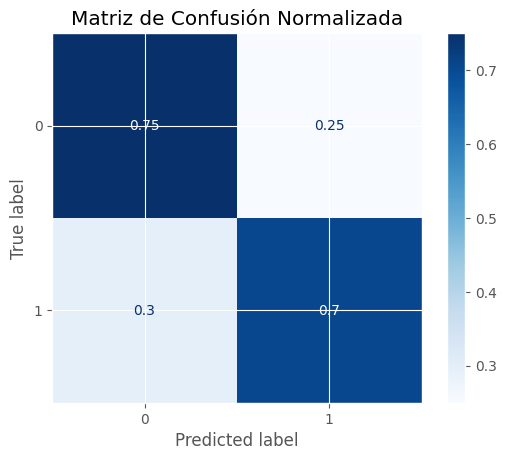

In [85]:
# Visualización de Resultados Logistic
plt.figure(figsize=(8, 6))
ConfusionMatrixDisplay.from_estimator(
    model_Logistic_pipeline, X_test, y_test, cmap='Blues', normalize='true')
plt.title("Matriz de Confusión Normalizada")
plt.show()

<div style="color:#800080; font-size:28px; font-weight:bold;">
    8. Conclusiones
</div>

In [86]:
# Precision 
from sklearn.metrics import precision_score
print("\nPrecisión")
print("=========")
print(f"De todas las veces que se predijo que No tiene diabetes (clase 0), el {precision_score(y_test, y_pred, pos_label=0)*100:.2f}% fueron correctas")
print(f"De todas las veces que se predijo que Si tiene diabetes (clase 1), el {precision_score(y_test, y_pred, pos_label=1)*100:.2f}% fueron correctas")

# Recall
print("\nRecall")
print("=========")
from sklearn.metrics import recall_score
print(f"De todas las personas que No tiene diabetes (clase 0), el {recall_score(y_test, y_pred, pos_label=0)*100:.2f}% les detecté que no tenian")
print(f"De todas las personas que Si tiene diabetes (clase 1), al {recall_score(y_test, y_pred, pos_label=1)*100:.2f}% les detecté que sí tenian")

# F1-Score
print("\nF1-Score (de 60% a 69% el modelo tiene rendimiento regular, de 70% a 79% aceptable, de 80% a 89% es muy bueno, y más de 90% es excelente)")
print("===========================================================================================================================================")
from sklearn.metrics import f1_score
print(f"El balance entre la precisión y el recall (promedio armonico) en la clase 0 es {f1_score(y_test, y_pred, pos_label=0)*100:.2f}%")
print(f"El balance entre la precisión y el recall (promedio armonico) en la clase 1 es {f1_score(y_test, y_pred, pos_label=1)*100:.2f}%")

# Accuracy
print("\nAccuracy (En bases desbalanceadas donde tienen muchos más de una clase que de la otra,el accuracy es engañoso y NO debe ser la métrica principal)")
print("==================================================================================================================================================")
from sklearn.metrics import accuracy_score
print(f"El porcentaje total de aciertos es {accuracy_score(y_test, y_pred)*100:.2f}%")

# ROC-AUC Score
print("\nROC-AUC Score (su nivel de distinción o separación de las clases es: <70% debil, 70%-79% regular, 80%-89% muy bueno, >=90% excelente (esto es bueno en salud))")
print("=================================================================================================================================================================")
from sklearn.metrics import roc_auc_score
print(f"En el {roc_auc_score(y_test, y_proba)*100:.2f}% de las veces, un paciente diabético recibe mayor probabilidad (de tener diabetes) que uno no diabético.")


Precisión
De todas las veces que se predijo que No tiene diabetes (clase 0), el 82.42% fueron correctas
De todas las veces que se predijo que Si tiene diabetes (clase 1), el 60.32% fueron correctas

Recall
De todas las personas que No tiene diabetes (clase 0), el 75.00% les detecté que no tenian
De todas las personas que Si tiene diabetes (clase 1), al 70.37% les detecté que sí tenian

F1-Score (de 60% a 69% el modelo tiene rendimiento regular, de 70% a 79% aceptable, de 80% a 89% es muy bueno, y más de 90% es excelente)
El balance entre la precisión y el recall (promedio armonico) en la clase 0 es 78.53%
El balance entre la precisión y el recall (promedio armonico) en la clase 1 es 64.96%

Accuracy (En bases desbalanceadas donde tienen muchos más de una clase que de la otra,el accuracy es engañoso y NO debe ser la métrica principal)
El porcentaje total de aciertos es 73.38%

ROC-AUC Score (su nivel de distinción o separación de las clases es: <70% debil, 70%-79% regular, 80%-89% muy 

<div style="color:#800080; font-size:28px; font-weight:bold;">
    9. Referencias
</div>

Link: https://www.kaggle.com/datasets/uciml/pima-indians-diabetes-database

<div style="color:#800080; font-size:28px; font-weight:bold;">
    10. Serialización y Producción (Adicional)
</div>

In [87]:
import sys
import os
import pickle
import json
import time

# ========================================
# MÉTODO 2: JOBLIB (Estándar ML)
# ========================================
joblib_path = '../app/models/model_joblib.joblib'
auc = roc_auc_score(y_test, model_Logistic_pipeline.predict_proba(X_test)[:, 1])

# Guardar CON metadatos (buena práctica)
artifact = {
    'model': model_Logistic_pipeline,
    'feature_names': X.columns.tolist(),
    'target_col': TARGET_COL,
    'auc_test': auc,
    'training_date': pd.Timestamp.now().isoformat(),
    'python_version': sys.version
    #'lightgbm_version': lgb.__version__
}

start = time.time()
joblib.dump(artifact, joblib_path, compress=3)  # compress=3 es buen balance
joblib_save_time = time.time() - start

# Cargar
start = time.time()
loaded_artifact = joblib.load(joblib_path)
joblib_load_time = time.time() - start

model_joblib = loaded_artifact['model']

# Verificar
pred_joblib = model_joblib.predict_proba(X_test)[:, 1]
auc_joblib = roc_auc_score(y_test, pred_joblib)

joblib_size = os.path.getsize(joblib_path) / 1024

print(f"📁 Archivo: {joblib_path}")
print(f"📦 Tamaño: {joblib_size:.2f} KB (comprimido)")
print(f"⏱️ Tiempo guardar: {joblib_save_time*1000:.2f} ms")
print(f"⏱️ Tiempo cargar: {joblib_load_time*1000:.2f} ms")
print(f"✅ AUC verificado: {auc_joblib:.4f}")
print(f"\n📋 Metadatos guardados: {list(loaded_artifact.keys())}")

📁 Archivo: ../app/models/model_joblib.joblib
📦 Tamaño: 2.04 KB (comprimido)
⏱️ Tiempo guardar: 0.00 ms
⏱️ Tiempo cargar: 19.80 ms
✅ AUC verificado: 0.8126

📋 Metadatos guardados: ['model', 'feature_names', 'target_col', 'auc_test', 'training_date', 'python_version']


In [88]:
import sklearn

# ========================================
# MÉTODO 5B: JSON + Metadatos (Para APIs)
# ========================================
json_path = '../app/models/model_metadata.json'

# Guardar metadatos en JSON (legible por cualquier lenguaje)
metadata = {
    'model_type': 'LogisticRegression',
    'model_file': 'model_texto.txt',
    'feature_names': X.columns.tolist(),
    'n_features': len(X.columns.tolist()),
    'target_col': TARGET_COL,
    
    'metrics': {
        'auc_test': round(auc, 4),
        'n_train_samples': len(X_train),
        'n_test_samples': len(X_test)
    },
    
    'training_info': {
        'date': pd.Timestamp.now().isoformat(),
        'version': sklearn.__version__        
    },
    
    #'feature_importance': dict(zip(
    #    X.columns.tolist(),
    #    model_Logistic_pipeline.feature_importances_.tolist()
    #))
}

with open(json_path, 'w') as f:
    json.dump(metadata, f, indent=2)

print(f"📁 Metadatos guardados: {json_path}")
print(f"\n📋 Contenido:")
print(json.dumps(metadata, indent=2)[:1000] + "...")

📁 Metadatos guardados: ../app/models/model_metadata.json

📋 Contenido:
{
  "model_type": "LogisticRegression",
  "model_file": "model_texto.txt",
  "feature_names": [
    "Pregnancies",
    "Glucose",
    "BloodPressure",
    "SkinThickness",
    "Insulin",
    "BMI",
    "DiabetesPedigreeFunction",
    "Age"
  ],
  "n_features": 8,
  "target_col": "Outcome",
  "metrics": {
    "auc_test": 0.8126,
    "n_train_samples": 614,
    "n_test_samples": 154
  },
  "training_info": {
    "date": "2025-12-13T20:41:10.398574",
    "version": "1.7.2"
  }
}...
